# **German Credit Card Worthiness Classification Using Deep Learning**

## 1.Importing Necessary Libraries


### 1.1 imports the libraries used for data handling, visualization, model building, and evaluation.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## 2.Loading and Preprocessing the Dataset

### 2.1 Load Dataset

In [3]:
file_path = "/content/german.data-numeric"
data = pd.read_csv(file_path, delimiter='\s+', header=None, usecols=range(21))

### 2.2 Add column names (from documentation)


In [4]:
columns = [
    "Status", "Duration", "CreditHistory", "Purpose", "CreditAmount",
    "SavingsAccount", "Employment", "InstallmentRate", "PersonalStatus", "OtherDebtors",
    "Residence", "Property", "Age", "OtherInstallmentPlans", "Housing",
    "ExistingCredits", "Job", "LiablePersons", "Telephone", "ForeignWorker", "CreditRisk"
]

data.columns = columns

### 2.3 Exploratory Data Analysis

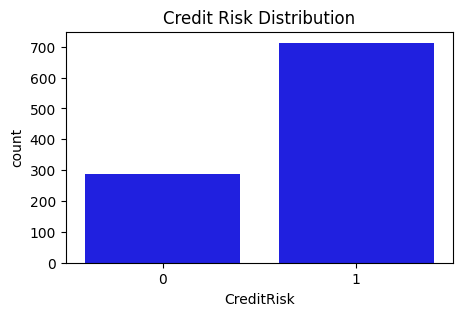

In [8]:
plt.figure(figsize=(5, 3))
sns.countplot(data=data, x='CreditRisk', color='blue')
plt.title('Credit Risk Distribution')
plt.show()

## 3.Feature Engineering and Splitting the Data

### 3.1 Feature Selection


In [9]:
X = data.drop('CreditRisk', axis=1)
y = data['CreditRisk']


### 3.2 Train-Test Split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### 3.3 Feature Scaling

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## 4.Random Forest Model with Hyperparameter Tuning


### 4.1 Define Parameter Grid


In [12]:
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}


### 4.2 Train Random Forest Model


In [13]:
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train)

print(f"Best Random Forest Parameters: {grid_search_rf.best_params_}")

rf_best = grid_search_rf.best_estimator_
rf_predictions = rf_best.predict(X_val_scaled)

print("Random Forest Classification Report:")
print(classification_report(y_val, rf_predictions))

Best Random Forest Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        57
           1       0.99      0.95      0.97       143

    accuracy                           0.95       200
   macro avg       0.94      0.96      0.95       200
weighted avg       0.96      0.95      0.96       200



## 5.Support Vector Machine Model


### 5.1 Define Parameter Grid


In [14]:
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

### 5.2 Train SVM Model

In [15]:
svc = SVC(probability=True, random_state=42)
grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid_svc, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svc.fit(X_train_scaled, y_train)

print(f"Best SVM Parameters: {grid_search_svc.best_params_}")

svc_best = grid_search_svc.best_estimator_
svc_predictions = svc_best.predict(X_val_scaled)

print("SVM Classification Report:")
print(classification_report(y_val, svc_predictions))

Best SVM Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        57
           1       0.99      0.95      0.97       143

    accuracy                           0.96       200
   macro avg       0.94      0.97      0.95       200
weighted avg       0.96      0.96      0.96       200



## 6.Comparing Models Using ROC Curves


In [16]:
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

### 6.1 Random Forest ROC


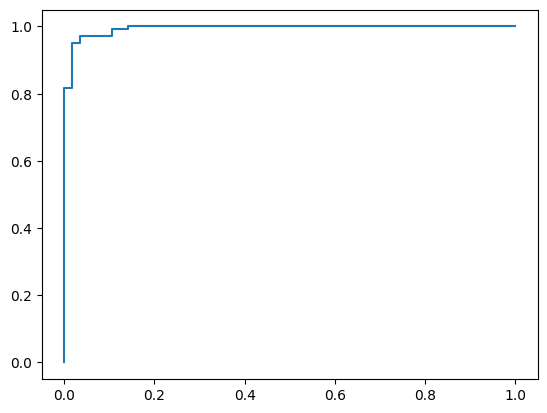

In [17]:
rf_probs = rf_best.predict_proba(X_val_scaled)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_val, rf_probs)
rf_auc = auc(rf_fpr, rf_tpr)
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})")

### 6.2 SVM ROC

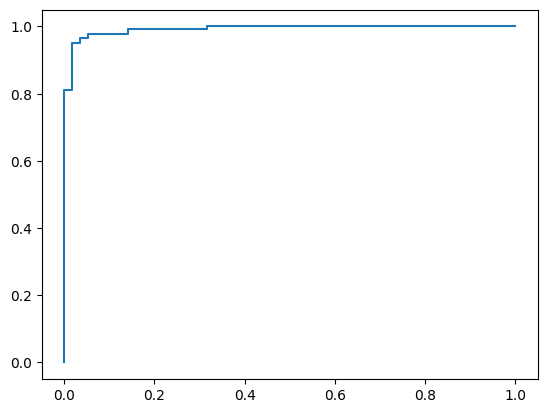

In [18]:
svc_probs = svc_best.predict_proba(X_val_scaled)[:, 1]
svc_fpr, svc_tpr, _ = roc_curve(y_val, svc_probs)
svc_auc = auc(svc_fpr, svc_tpr)
plt.plot(svc_fpr, svc_tpr, label=f"SVM (AUC = {svc_auc:.2f})")

### 6.3 Baseline

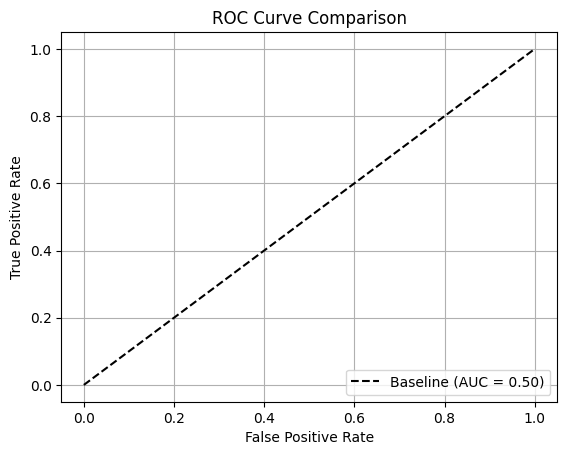

In [19]:
plt.plot([0, 1], [0, 1], 'k--', label='Baseline (AUC = 0.50)')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

## 7.Building and Training a Neural Network


### 7.1 Define the Model


In [23]:
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

### 7.2 Compile the *Model*

In [24]:
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

### 7.3 Early Stopping Callback

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)


### 7.4 Train the Model

In [26]:
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6510 - loss: 0.6746 - val_accuracy: 0.7200 - val_loss: 0.5563
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7141 - loss: 0.5727 - val_accuracy: 0.7400 - val_loss: 0.5084
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7225 - loss: 0.5675 - val_accuracy: 0.7950 - val_loss: 0.4661
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7772 - loss: 0.4787 - val_accuracy: 0.8350 - val_loss: 0.4241
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8053 - loss: 0.4498 - val_accuracy: 0.8600 - val_loss: 0.3851
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8230 - loss: 0.4071 - val_accuracy: 0.8800 - val_loss: 0.3487
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8310 - loss: 0.3841 - val_accuracy: 0.8900 - val_loss: 0.3140
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8517 - loss: 0.3702 - val_accuracy: 0.9250 - 

### 7.5 Visualize Training History


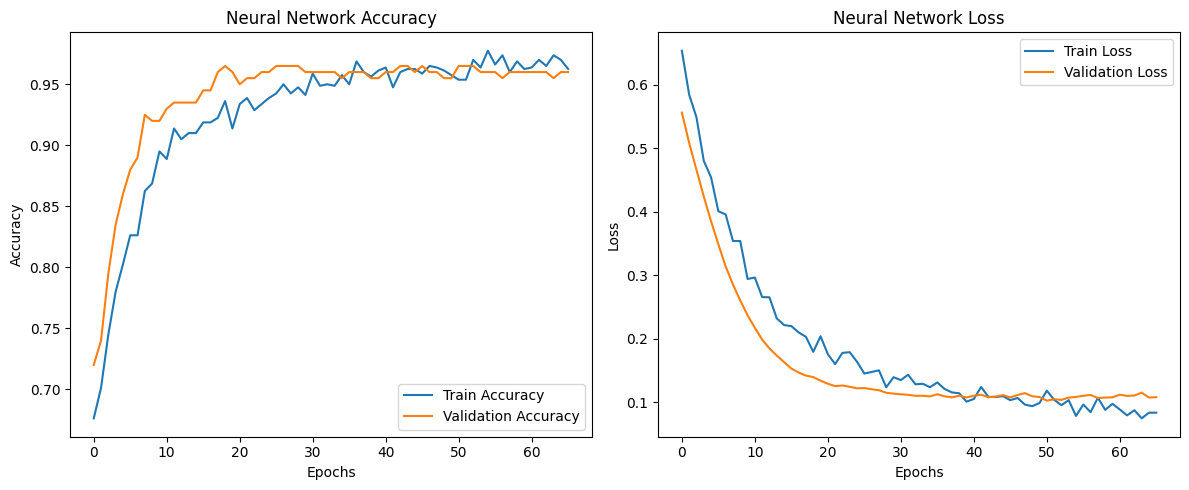

In [30]:
plt.figure(figsize=(12, 5))

#Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### 7.8 Evaluate Neural Network Model


In [31]:
nn_predictions = (model.predict(X_val_scaled) > 0.5).astype(int)
print("Neural Network Classification Report:")
print(classification_report(y_val, nn_predictions))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        57
           1       0.99      0.97      0.98       143

    accuracy                           0.96       200
   macro avg       0.95      0.96      0.96       200
weighted avg       0.97      0.96      0.97       200



## 8.Saving Artifacts


### 8.1 Save Best Model (Random Forest)


In [32]:
import joblib
joblib.dump(rf_best, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

### 8.2 Save Scaler


In [33]:
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']